# Experiment 1
- Pre-trained model: BERT-based TAPE model => 12개의 encoder layers

- Fine-tuning rounds:
    - Round 1
        - 말단 10개의 encoder와 classifier를 Dash, VDJdb, McPAS 데이터를 사용하여 fine-tuning
        - 150 epochs with early stopping until 15 epochs
        - Adam optimizer with lr: 1e-4
    - Round 2
        - 말단 6개 encoder와 classifier를 IEDB SARS-2 데이터를 사용하여 fine-tuning
        - 100 epochs with early stopping until 10 epochs
        - Adam optimizer with lr: 1e-5
        
- Model evaluation
    - COVID-19 S-protein269-277(YLQPRTFLL) with the epitope-specific TCRβs from recent two studies
    - 352 TCRbeta from Shomuradova et al, 415 TCRbeta from ImmuneCODE
    - Attention 분석을 통해 TCR CDR3beta와 에피토프 펩타이드 서열의 모티프를 식별한다.
   

## Global configurations

In [2]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

2021-10-05 04:14:35 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoder

{'title': 'exp1',
 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'adam', 'lr': 0.0001},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': '../output/exp1/train.{round}.result.json'},
   {'data': 'iedb_sars2',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'t

## Exploring fine-tuning datasets

### Dash + VDJdb + McPAS

In [2]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

train_ds = TCREpitopeSentenceDataset.from_key('dash_vdjdb_mcpas')
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp, tmp.shape)
display(train_df.label.value_counts())

display(train_df[train_ds.CN_SENTENCE].map(lambda x: ''.join(sent_encoder.to_tokens(x))))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
GLCTLVAML_CASSLWTGSHEQYF,GLCTLVAML,BMLF,EBV,human,CASSLWTGSHEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSQSPGGEQYF,GLCTLVAML,BMLF,EBV,human,CASSQSPGGEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSLTTEQQFF,GLCTLVAML,BMLF,EBV,human,CASSLTTEQQFF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CSARDATGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDATGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."
GLCTLVAML_CSARDSTGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDSTGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."


(25138, 9)

LPRRSGAAGA      4284
GILGFVFTL       2560
GLCTLVAML       1858
NLVPMVATV       1370
CRVLCCYVL        870
SSLENFRAYV       840
TPRVTGGGAM       696
SSYRRPVGI        686
ELAGIGILTV       576
ASNENMETM        570
EAAGIGILTV       566
VTEHDTLLY        546
FRCPRRFCF        532
LLWNGPMAV        478
KRWIILGLNK       464
RAKFKQLL         440
RPHERNGFTVL      412
HGIRNASFI        402
LSLRNPILV        372
KAFSPEVIPMF      344
ATDALMTGY        306
CTPYDINQM        304
SFHSLHLLF        276
FLCMKALLL        272
TTPESANL         228
FPRPWLHGL        190
KLVALGINAV       188
EIYKRWII         188
YVLDHLIVV        184
FLKEKGGL         180
TPQDLNTML        150
IPSINVHHY        150
SSPPMFRV         148
TVYGFCLL         146
NLNCCSVPV        140
STPESANL         138
LPPIVAKEI        128
YSEHPTFTSQY      126
HPKVSSEVHI       126
NEGVKAAW         124
TPGPGVRYPL       124
GTSGSPIVNR       124
GPGHKARVL        112
IMNDMPIYM        110
GTSGSPIINR        96
KMVAVFYTT         94
MLNIPSINV         92
HSKKKCDEL    

(78,)

0    12569
1    12569
Name: label, dtype: int64

GLCTLVAML_CASSLWTGSHEQYF     <cls>GLCTLVAMLCASSLWTGSHEQYF<sep><pad><pad><pa...
GLCTLVAML_CASSQSPGGEQYF      <cls>GLCTLVAMLCASSQSPGGEQYF<sep><pad><pad><pad...
GLCTLVAML_CASSLTTEQQFF       <cls>GLCTLVAMLCASSLTTEQQFF<sep><pad><pad><pad>...
GLCTLVAML_CSARDATGNGYTF      <cls>GLCTLVAMLCSARDATGNGYTF<sep><pad><pad><pad...
GLCTLVAML_CSARDSTGNGYTF      <cls>GLCTLVAMLCSARDSTGNGYTF<sep><pad><pad><pad...
                                                   ...                        
YVLDHLIVV_CASHAGTLKEKLFF     <cls>YVLDHLIVVCASHAGTLKEKLFF<sep><pad><pad><pa...
YVLDHLIVV_CAISDETEAFF        <cls>YVLDHLIVVCAISDETEAFF<sep><pad><pad><pad><...
YVLDHLIVV_CASRPGQINQPQHF     <cls>YVLDHLIVVCASRPGQINQPQHF<sep><pad><pad><pa...
YVLDHLIVV_CSAFALSPSTDTQYF    <cls>YVLDHLIVVCSAFALSPSTDTQYF<sep><pad><pad><p...
YVLDHLIVV_CASSPGVTGEKLFF     <cls>YVLDHLIVVCASSPGVTGEKLFF<sep><pad><pad><pa...
Name: sentence, Length: 25138, dtype: object

0

### IEDB SARS-Cov-2

In [3]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

train_ds = TCREpitopeSentenceDataset.from_key('iedb_sars2')
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp, tmp.shape)
display(train_df.label.value_counts())

display(train_df[train_ds.CN_SENTENCE].map(lambda x: ''.join(sent_encoder.to_tokens(x))))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
FLPFFSNVTWFHAI_CASSIRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIGVYGYTF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIGVYGYTF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSSRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSSRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSTRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSTRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."


(98563, 9)

HTTDPSFLGRY        11586
SEHDYQIGGYTEKW      6848
FLNGSCGSV           5136
KLSYGIATV           4920
AELAKNVSLDNVL       3588
APKEIIFLEGETL       3572
LSPRWYFYYL          3502
KLPDDFTGCV          2638
VLPFNDGVYFASTEK     2593
VQELYSPIFLIV        2126
GMEVTPSGTWLTY       1990
LLLDDFVEII          1936
SELVIGAVIL          1800
RQLLFVVEV           1784
YEDFLEYHDVRVVL      1752
FLPRVFSAV           1734
KAYNVTQAF           1614
VLPPLLTDEMIAQYT     1348
TVLSFCAFAV          1226
WICLLQFAY           1180
TLIGDCATV           1138
NPLLYDANYFLCW       1096
YEQYIKWPWYI         1074
VLHSYFTSDYYQLY       970
RSVASQSIIAYTMSL      940
SNEKQEILGTVSWNL      902
YLNTLTLAV            864
FGEVFNATRFASVY       836
LEPLVDLPI            834
YFPLQSYGF            796
YYVGYLQPRTFLL        730
KPLEFGATSAAL         724
ALRKVPTDNYITTY       692
AYKTFPPTEPK          676
KLWAQCVQL            624
RNPANNAAIVL          622
FLPFFSNVTWFHAI       602
VYSTGSNVFQTR         572
NRDVDTDFVNEFYAY      570
SEVGPEHSLAEY         542


(145,)

1    49282
0    49281
Name: label, dtype: int64

FLPFFSNVTWFHAI_CASSIRSSYEQYF     <cls>FLPFFSNVTWFHAICASSIRSSYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSIGVYGYTF      <cls>FLPFFSNVTWFHAICASSIGVYGYTF<sep><pad><pad>...
FLPFFSNVTWFHAI_CASSIRSAYEQYF     <cls>FLPFFSNVTWFHAICASSIRSAYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSSRSSYEQYF     <cls>FLPFFSNVTWFHAICASSSRSSYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSTRSAYEQYF     <cls>FLPFFSNVTWFHAICASSTRSAYEQYF<sep><pad><pad...
                                                       ...                        
YYVGYLQPRTFLL_CASSLGDGTEAFF      <cls>YYVGYLQPRTFLLCASSLGDGTEAFF<sep><pad><pad>...
YYVGYLQPRTFLL_CASSAGDSYEQYF      <cls>YYVGYLQPRTFLLCASSAGDSYEQYF<sep><pad><pad>...
YYVGYLQPRTFLL_CASSQDTYQETQYF     <cls>YYVGYLQPRTFLLCASSQDTYQETQYF<sep><pad><pad...
YYVGYLQPRTFLL_CASSGDRVGTDTQYF    <cls>YYVGYLQPRTFLLCASSGDRVGTDTQYF<sep><pad><pa...
YYVGYLQPRTFLL_CASSLDLAAGEQYF     <cls>YYVGYLQPRTFLLCASSLDLAAGEQYF<sep><pad><pad...
Name: sentence, Length: 98563, dtype: object

0

## Fine-tuning

In [4]:
experiment.train()

2021-10-02 23:39:46 [INFO]: ======================
2021-10-02 23:39:46 [INFO]: Begin train at 2021-10-02 23:39:46.632207
2021-10-02 23:39:46 [INFO]: Loading the TAPE pretrained model from ../config/bert-base/
2021-10-02 23:39:49 [INFO]: Start 2 train rounds of exp1 at 2021-10-02 23:39:46.632207
2021-10-02 23:39:49 [INFO]: train_conf: {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'm

2021-10-02 23:39:53 [INFO]: train.n_data: 20110, test.n_data: 5028
2021-10-02 23:39:53 [INFO]: optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
2021-10-02 23:39:53 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f039a779a50>
2021-10-02 23:39:53 [INFO]: n_epochs: 150
2021-10-02 23:39:53 [INFO]: train.batch_size: 128
2021-10-02 23:39:53 [INFO]: test.batch_size: 128


Validating in epoch 0/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-10-02 23:43:56 [INFO]: [EvalScoreRecoder]: In epoch 0/150, loss train score: 0.685416607539865, val score: 0.6748630315065384
2021-10-02 23:43:56 [INFO]: [EvalScoreRecoder]: In epoch 0/150, accuracy train score: 0.5535078548824593, val score: 0.5826822916666666
2021-10-02 23:43:56 [INFO]: [EarlyStopper]: In epoch 0/150, accuracy score: 0.5826822916666666, best accuracy score: -inf;update best score to 0.5826822916666666
2021-10-02 23:43:56 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 0: accuracy improved from -inf to 0.5826822916666666, saving model to ../output/exp1/train.0.model_0.chk



Validating in epoch 1/150: 100%|██████████| 40/40 [00:37<00:00,  1.08batch/s]

2021-10-02 23:47:57 [INFO]: [EvalScoreRecoder]: In epoch 1/150, loss train score: 0.6406082963641686, val score: 0.5948871232569217
2021-10-02 23:47:57 [INFO]: [EvalScoreRecoder]: In epoch 1/150, accuracy train score: 0.6211502599457505, val score: 0.663259548611111
2021-10-02 23:47:57 [INFO]: [EarlyStopper]: In epoch 1/150, accuracy score: 0.663259548611111, best accuracy score: 0.5826822916666666;update best score to 0.663259548611111
2021-10-02 23:47:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy improved from 0.5826822916666666 to 0.663259548611111, saving model to ../output/exp1/train.0.model_1.chk



Validating in epoch 2/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-02 23:51:56 [INFO]: [EvalScoreRecoder]: In epoch 2/150, loss train score: 0.5622627052325236, val score: 0.570823023468256
2021-10-02 23:51:56 [INFO]: [EvalScoreRecoder]: In epoch 2/150, accuracy train score: 0.6894637206148282, val score: 0.690256076388889
2021-10-02 23:51:56 [INFO]: [EarlyStopper]: In epoch 2/150, accuracy score: 0.690256076388889, best accuracy score: 0.663259548611111;update best score to 0.690256076388889
2021-10-02 23:51:56 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 2: accuracy improved from 0.663259548611111 to 0.690256076388889, saving model to ../output/exp1/train.0.model_2.chk



Validating in epoch 3/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-02 23:56:30 [INFO]: [EvalScoreRecoder]: In epoch 3/150, loss train score: 0.5082104169303858, val score: 0.5534651964902878
2021-10-02 23:56:30 [INFO]: [EvalScoreRecoder]: In epoch 3/150, accuracy train score: 0.7288370253164557, val score: 0.7004774305555556
2021-10-02 23:56:30 [INFO]: [EarlyStopper]: In epoch 3/150, accuracy score: 0.7004774305555556, best accuracy score: 0.690256076388889;update best score to 0.7004774305555556
2021-10-02 23:56:30 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 3: accuracy improved from 0.690256076388889 to 0.7004774305555556, saving model to ../output/exp1/train.0.model_3.chk



Validating in epoch 4/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 00:00:30 [INFO]: [EvalScoreRecoder]: In epoch 4/150, loss train score: 0.4631078906262977, val score: 0.7059741169214249
2021-10-03 00:00:30 [INFO]: [EvalScoreRecoder]: In epoch 4/150, accuracy train score: 0.7653777689873418, val score: 0.6777994791666666
2021-10-03 00:00:30 [INFO]: [EarlyStopper]: In epoch 4/150, accuracy score: 0.6777994791666666, best accuracy score: 0.7004774305555556;accuracy score was not improved
2021-10-03 00:00:30 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 00:00:30 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 4: accuracy did not improve



Validating in epoch 5/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-10-03 00:04:29 [INFO]: [EvalScoreRecoder]: In epoch 5/150, loss train score: 0.40755725227579287, val score: 0.6951736122369766
2021-10-03 00:04:29 [INFO]: [EvalScoreRecoder]: In epoch 5/150, accuracy train score: 0.7995450949367089, val score: 0.683376736111111
2021-10-03 00:04:29 [INFO]: [EarlyStopper]: In epoch 5/150, accuracy score: 0.683376736111111, best accuracy score: 0.7004774305555556;accuracy score was not improved
2021-10-03 00:04:29 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 00:04:29 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 5: accuracy did not improve



Validating in epoch 6/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 00:08:57 [INFO]: [EvalScoreRecoder]: In epoch 6/150, loss train score: 0.35500246352410014, val score: 0.6996993124485016
2021-10-03 00:08:57 [INFO]: [EvalScoreRecoder]: In epoch 6/150, accuracy train score: 0.8355419303797469, val score: 0.7068359375
2021-10-03 00:08:57 [INFO]: [EarlyStopper]: In epoch 6/150, accuracy score: 0.7068359375, best accuracy score: 0.7004774305555556;update best score to 0.7068359375
2021-10-03 00:08:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 6: accuracy improved from 0.7004774305555556 to 0.7068359375, saving model to ../output/exp1/train.0.model_6.chk



Validating in epoch 7/150: 100%|██████████| 40/40 [00:37<00:00,  1.05batch/s]

2021-10-03 00:12:57 [INFO]: [EvalScoreRecoder]: In epoch 7/150, loss train score: 0.3013963011517838, val score: 0.7619759634137153
2021-10-03 00:12:57 [INFO]: [EvalScoreRecoder]: In epoch 7/150, accuracy train score: 0.867879746835443, val score: 0.717599826388889
2021-10-03 00:12:57 [INFO]: [EarlyStopper]: In epoch 7/150, accuracy score: 0.717599826388889, best accuracy score: 0.7068359375;update best score to 0.717599826388889
2021-10-03 00:12:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 7: accuracy improved from 0.7068359375 to 0.717599826388889, saving model to ../output/exp1/train.0.model_7.chk



Validating in epoch 8/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-10-03 00:16:54 [INFO]: [EvalScoreRecoder]: In epoch 8/150, loss train score: 0.26861469755892325, val score: 0.7391107387840747
2021-10-03 00:16:54 [INFO]: [EvalScoreRecoder]: In epoch 8/150, accuracy train score: 0.8830102848101266, val score: 0.7303602430555556
2021-10-03 00:16:54 [INFO]: [EarlyStopper]: In epoch 8/150, accuracy score: 0.7303602430555556, best accuracy score: 0.717599826388889;update best score to 0.7303602430555556
2021-10-03 00:16:54 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 8: accuracy improved from 0.717599826388889 to 0.7303602430555556, saving model to ../output/exp1/train.0.model_8.chk



Validating in epoch 9/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 00:20:53 [INFO]: [EvalScoreRecoder]: In epoch 9/150, loss train score: 0.20106047450541223, val score: 0.9193572029471397
2021-10-03 00:20:53 [INFO]: [EvalScoreRecoder]: In epoch 9/150, accuracy train score: 0.9156447784810127, val score: 0.7222439236111111
2021-10-03 00:20:53 [INFO]: [EarlyStopper]: In epoch 9/150, accuracy score: 0.7222439236111111, best accuracy score: 0.7303602430555556;accuracy score was not improved
2021-10-03 00:20:53 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 00:20:53 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 9: accuracy did not improve



Validating in epoch 10/150: 100%|██████████| 40/40 [00:37<00:00,  1.05batch/s]

2021-10-03 00:25:10 [INFO]: [EvalScoreRecoder]: In epoch 10/150, loss train score: 0.1667599884035726, val score: 0.8274986043572425
2021-10-03 00:25:10 [INFO]: [EvalScoreRecoder]: In epoch 10/150, accuracy train score: 0.9334454113924051, val score: 0.7375
2021-10-03 00:25:10 [INFO]: [EarlyStopper]: In epoch 10/150, accuracy score: 0.7375, best accuracy score: 0.7303602430555556;update best score to 0.7375
2021-10-03 00:25:10 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 10: accuracy improved from 0.7303602430555556 to 0.7375, saving model to ../output/exp1/train.0.model_10.chk



Validating in epoch 11/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 00:29:09 [INFO]: [EvalScoreRecoder]: In epoch 11/150, loss train score: 0.13923232817780698, val score: 0.8658847853541374
2021-10-03 00:29:09 [INFO]: [EvalScoreRecoder]: In epoch 11/150, accuracy train score: 0.946153085443038, val score: 0.7248046875
2021-10-03 00:29:09 [INFO]: [EarlyStopper]: In epoch 11/150, accuracy score: 0.7248046875, best accuracy score: 0.7375;accuracy score was not improved
2021-10-03 00:29:09 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 00:29:09 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 11: accuracy did not improve



Validating in epoch 12/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 00:33:06 [INFO]: [EvalScoreRecoder]: In epoch 12/150, loss train score: 0.11968574713019631, val score: 0.957202136516571
2021-10-03 00:33:06 [INFO]: [EvalScoreRecoder]: In epoch 12/150, accuracy train score: 0.9547567246835443, val score: 0.7503038194444445
2021-10-03 00:33:06 [INFO]: [EarlyStopper]: In epoch 12/150, accuracy score: 0.7503038194444445, best accuracy score: 0.7375;update best score to 0.7503038194444445
2021-10-03 00:33:06 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 12: accuracy improved from 0.7375 to 0.7503038194444445, saving model to ../output/exp1/train.0.model_12.chk



Validating in epoch 13/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-10-03 00:37:07 [INFO]: [EvalScoreRecoder]: In epoch 13/150, loss train score: 0.11132303596020358, val score: 0.9494324192404747
2021-10-03 00:37:07 [INFO]: [EvalScoreRecoder]: In epoch 13/150, accuracy train score: 0.9569323575949367, val score: 0.7461805555555555
2021-10-03 00:37:07 [INFO]: [EarlyStopper]: In epoch 13/150, accuracy score: 0.7461805555555555, best accuracy score: 0.7503038194444445;accuracy score was not improved
2021-10-03 00:37:07 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 00:37:07 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 13: accuracy did not improve



Validating in epoch 14/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-10-03 00:41:08 [INFO]: [EvalScoreRecoder]: In epoch 14/150, loss train score: 0.09145433799499245, val score: 1.0002603709697724
2021-10-03 00:41:08 [INFO]: [EvalScoreRecoder]: In epoch 14/150, accuracy train score: 0.9656348892405063, val score: 0.7446180555555555
2021-10-03 00:41:08 [INFO]: [EarlyStopper]: In epoch 14/150, accuracy score: 0.7446180555555555, best accuracy score: 0.7503038194444445;accuracy score was not improved
2021-10-03 00:41:08 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 00:41:08 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 14: accuracy did not improve



Validating in epoch 16/150: 100%|██████████| 40/40 [00:38<00:00,  1.04batch/s]

2021-10-03 00:49:07 [INFO]: [EvalScoreRecoder]: In epoch 16/150, loss train score: 0.07780282500589007, val score: 1.1175270453095436
2021-10-03 00:49:07 [INFO]: [EvalScoreRecoder]: In epoch 16/150, accuracy train score: 0.9722606803797469, val score: 0.7424913194444445
2021-10-03 00:49:07 [INFO]: [EarlyStopper]: In epoch 16/150, accuracy score: 0.7424913194444445, best accuracy score: 0.7503038194444445;accuracy score was not improved
2021-10-03 00:49:07 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-10-03 00:49:07 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 16: accuracy did not improve



Validating in epoch 17/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-10-03 00:53:12 [INFO]: [EvalScoreRecoder]: In epoch 17/150, loss train score: 0.07055566298386341, val score: 0.8583766877651214
2021-10-03 00:53:12 [INFO]: [EvalScoreRecoder]: In epoch 17/150, accuracy train score: 0.9744786957504522, val score: 0.7516710069444444
2021-10-03 00:53:12 [INFO]: [EarlyStopper]: In epoch 17/150, accuracy score: 0.7516710069444444, best accuracy score: 0.7503038194444445;update best score to 0.7516710069444444
2021-10-03 00:53:12 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 17: accuracy improved from 0.7503038194444445 to 0.7516710069444444, saving model to ../output/exp1/train.0.model_17.chk



Validating in epoch 18/150: 100%|██████████| 40/40 [00:38<00:00,  1.04batch/s]

2021-10-03 00:57:15 [INFO]: [EvalScoreRecoder]: In epoch 18/150, loss train score: 0.07417477194007628, val score: 1.0360615894198417
2021-10-03 00:57:15 [INFO]: [EvalScoreRecoder]: In epoch 18/150, accuracy train score: 0.9729034810126582, val score: 0.7418836805555555
2021-10-03 00:57:15 [INFO]: [EarlyStopper]: In epoch 18/150, accuracy score: 0.7418836805555555, best accuracy score: 0.7516710069444444;accuracy score was not improved
2021-10-03 00:57:15 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 00:57:15 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 18: accuracy did not improve



Validating in epoch 19/150: 100%|██████████| 40/40 [00:40<00:00,  1.02s/batch]

2021-10-03 01:01:18 [INFO]: [EvalScoreRecoder]: In epoch 19/150, loss train score: 0.053366897254887545, val score: 1.1682468503713608
2021-10-03 01:01:18 [INFO]: [EvalScoreRecoder]: In epoch 19/150, accuracy train score: 0.9808643196202531, val score: 0.7441623263888889
2021-10-03 01:01:18 [INFO]: [EarlyStopper]: In epoch 19/150, accuracy score: 0.7441623263888889, best accuracy score: 0.7516710069444444;accuracy score was not improved
2021-10-03 01:01:18 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 01:01:18 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 19: accuracy did not improve



Validating in epoch 20/150: 100%|██████████| 40/40 [00:39<00:00,  1.02batch/s]

2021-10-03 01:05:37 [INFO]: [EvalScoreRecoder]: In epoch 20/150, loss train score: 0.05438033065204568, val score: 1.1608779087662697
2021-10-03 01:05:37 [INFO]: [EvalScoreRecoder]: In epoch 20/150, accuracy train score: 0.9808078096745028, val score: 0.75390625
2021-10-03 01:05:37 [INFO]: [EarlyStopper]: In epoch 20/150, accuracy score: 0.75390625, best accuracy score: 0.7516710069444444;update best score to 0.75390625
2021-10-03 01:05:37 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 20: accuracy improved from 0.7516710069444444 to 0.75390625, saving model to ../output/exp1/train.0.model_20.chk



Validating in epoch 21/150: 100%|██████████| 40/40 [00:40<00:00,  1.01s/batch]

2021-10-03 01:09:50 [INFO]: [EvalScoreRecoder]: In epoch 21/150, loss train score: 0.06414230405632997, val score: 1.118401001393795
2021-10-03 01:09:50 [INFO]: [EvalScoreRecoder]: In epoch 21/150, accuracy train score: 0.9773041930379747, val score: 0.7539930555555555
2021-10-03 01:09:50 [INFO]: [EarlyStopper]: In epoch 21/150, accuracy score: 0.7539930555555555, best accuracy score: 0.75390625;update best score to 0.7539930555555555
2021-10-03 01:09:50 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 21: accuracy improved from 0.75390625 to 0.7539930555555555, saving model to ../output/exp1/train.0.model_21.chk



Validating in epoch 22/150: 100%|██████████| 40/40 [00:39<00:00,  1.00batch/s]

2021-10-03 01:14:07 [INFO]: [EvalScoreRecoder]: In epoch 22/150, loss train score: 0.047322257437107385, val score: 1.0287435486912728
2021-10-03 01:14:07 [INFO]: [EvalScoreRecoder]: In epoch 22/150, accuracy train score: 0.9835838607594937, val score: 0.7616102430555556
2021-10-03 01:14:07 [INFO]: [EarlyStopper]: In epoch 22/150, accuracy score: 0.7616102430555556, best accuracy score: 0.7539930555555555;update best score to 0.7616102430555556
2021-10-03 01:14:07 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 22: accuracy improved from 0.7539930555555555 to 0.7616102430555556, saving model to ../output/exp1/train.0.model_22.chk



Validating in epoch 23/150: 100%|██████████| 40/40 [00:40<00:00,  1.01s/batch]

2021-10-03 01:18:25 [INFO]: [EvalScoreRecoder]: In epoch 23/150, loss train score: 0.042946015074967016, val score: 1.1821334674954413
2021-10-03 01:18:25 [INFO]: [EvalScoreRecoder]: In epoch 23/150, accuracy train score: 0.9849683544303798, val score: 0.7613064236111111
2021-10-03 01:18:25 [INFO]: [EarlyStopper]: In epoch 23/150, accuracy score: 0.7613064236111111, best accuracy score: 0.7616102430555556;accuracy score was not improved
2021-10-03 01:18:25 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 01:18:25 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 23: accuracy did not improve



Validating in epoch 24/150: 100%|██████████| 40/40 [00:40<00:00,  1.02s/batch]

2021-10-03 01:22:46 [INFO]: [EvalScoreRecoder]: In epoch 24/150, loss train score: 0.04576880046180479, val score: 1.117977799475193
2021-10-03 01:22:46 [INFO]: [EvalScoreRecoder]: In epoch 24/150, accuracy train score: 0.983682753164557, val score: 0.7596571180555556
2021-10-03 01:22:46 [INFO]: [EarlyStopper]: In epoch 24/150, accuracy score: 0.7596571180555556, best accuracy score: 0.7616102430555556;accuracy score was not improved
2021-10-03 01:22:46 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 01:22:46 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 24: accuracy did not improve



Validating in epoch 25/150: 100%|██████████| 40/40 [00:47<00:00,  1.18s/batch]

2021-10-03 01:27:07 [INFO]: [EvalScoreRecoder]: In epoch 25/150, loss train score: 0.038498973276442555, val score: 1.2220110327005387
2021-10-03 01:27:07 [INFO]: [EvalScoreRecoder]: In epoch 25/150, accuracy train score: 0.9865506329113924, val score: 0.7585069444444444
2021-10-03 01:27:07 [INFO]: [EarlyStopper]: In epoch 25/150, accuracy score: 0.7585069444444444, best accuracy score: 0.7616102430555556;accuracy score was not improved
2021-10-03 01:27:07 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-10-03 01:27:07 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 25: accuracy did not improve



Validating in epoch 27/150: 100%|██████████| 40/40 [00:41<00:00,  1.04s/batch]

2021-10-03 01:35:42 [INFO]: [EvalScoreRecoder]: In epoch 27/150, loss train score: 0.037753869602574576, val score: 1.2298488855361938
2021-10-03 01:35:42 [INFO]: [EvalScoreRecoder]: In epoch 27/150, accuracy train score: 0.9877373417721519, val score: 0.7630642361111111
2021-10-03 01:35:42 [INFO]: [EarlyStopper]: In epoch 27/150, accuracy score: 0.7630642361111111, best accuracy score: 0.7616102430555556;update best score to 0.7630642361111111
2021-10-03 01:35:42 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 27: accuracy improved from 0.7616102430555556 to 0.7630642361111111, saving model to ../output/exp1/train.0.model_27.chk



Validating in epoch 28/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 01:40:09 [INFO]: [EvalScoreRecoder]: In epoch 28/150, loss train score: 0.05019588052012215, val score: 1.0229157745838164
2021-10-03 01:40:09 [INFO]: [EvalScoreRecoder]: In epoch 28/150, accuracy train score: 0.9827432753164557, val score: 0.7658203125
2021-10-03 01:40:09 [INFO]: [EarlyStopper]: In epoch 28/150, accuracy score: 0.7658203125, best accuracy score: 0.7630642361111111;update best score to 0.7658203125
2021-10-03 01:40:09 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 28: accuracy improved from 0.7630642361111111 to 0.7658203125, saving model to ../output/exp1/train.0.model_28.chk



Validating in epoch 29/150: 100%|██████████| 40/40 [00:47<00:00,  1.20s/batch]

2021-10-03 01:44:32 [INFO]: [EvalScoreRecoder]: In epoch 29/150, loss train score: 0.03522039980139831, val score: 1.009060153365135
2021-10-03 01:44:32 [INFO]: [EvalScoreRecoder]: In epoch 29/150, accuracy train score: 0.9875395569620253, val score: 0.7598741319444444
2021-10-03 01:44:32 [INFO]: [EarlyStopper]: In epoch 29/150, accuracy score: 0.7598741319444444, best accuracy score: 0.7658203125;accuracy score was not improved
2021-10-03 01:44:32 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 01:44:32 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 29: accuracy did not improve



Validating in epoch 31/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 01:53:05 [INFO]: [EvalScoreRecoder]: In epoch 31/150, loss train score: 0.034048012627621735, val score: 1.223763856291771
2021-10-03 01:53:05 [INFO]: [EvalScoreRecoder]: In epoch 31/150, accuracy train score: 0.9888746044303798, val score: 0.7612413194444445
2021-10-03 01:53:05 [INFO]: [EarlyStopper]: In epoch 31/150, accuracy score: 0.7612413194444445, best accuracy score: 0.7689670138888889;accuracy score was not improved
2021-10-03 01:53:05 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 01:53:05 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 31: accuracy did not improve



Validating in epoch 32/150: 100%|██████████| 40/40 [00:39<00:00,  1.01batch/s]

2021-10-03 01:57:16 [INFO]: [EvalScoreRecoder]: In epoch 32/150, loss train score: 0.034181828442975716, val score: 1.1103666797280312
2021-10-03 01:57:16 [INFO]: [EvalScoreRecoder]: In epoch 32/150, accuracy train score: 0.9881823575949367, val score: 0.7567057291666666
2021-10-03 01:57:16 [INFO]: [EarlyStopper]: In epoch 32/150, accuracy score: 0.7567057291666666, best accuracy score: 0.7689670138888889;accuracy score was not improved
2021-10-03 01:57:16 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 01:57:16 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 32: accuracy did not improve



Validating in epoch 33/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 02:01:27 [INFO]: [EvalScoreRecoder]: In epoch 33/150, loss train score: 0.03580799264284595, val score: 1.1832365840673447
2021-10-03 02:01:27 [INFO]: [EvalScoreRecoder]: In epoch 33/150, accuracy train score: 0.98828125, val score: 0.7545138888888889
2021-10-03 02:01:27 [INFO]: [EarlyStopper]: In epoch 33/150, accuracy score: 0.7545138888888889, best accuracy score: 0.7689670138888889;accuracy score was not improved
2021-10-03 02:01:27 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-10-03 02:01:27 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 33: accuracy did not improve



Validating in epoch 34/150: 100%|██████████| 40/40 [00:39<00:00,  1.00batch/s]

2021-10-03 02:05:53 [INFO]: [EvalScoreRecoder]: In epoch 34/150, loss train score: 0.035799676307795354, val score: 1.410700622200966
2021-10-03 02:05:53 [INFO]: [EvalScoreRecoder]: In epoch 34/150, accuracy train score: 0.9871934335443038, val score: 0.755859375
2021-10-03 02:05:53 [INFO]: [EarlyStopper]: In epoch 34/150, accuracy score: 0.755859375, best accuracy score: 0.7689670138888889;accuracy score was not improved
2021-10-03 02:05:53 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-10-03 02:05:53 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 34: accuracy did not improve



Validating in epoch 35/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 02:10:05 [INFO]: [EvalScoreRecoder]: In epoch 35/150, loss train score: 0.03414937845137283, val score: 1.038359871506691
2021-10-03 02:10:05 [INFO]: [EvalScoreRecoder]: In epoch 35/150, accuracy train score: 0.9877867879746836, val score: 0.7593532986111111
2021-10-03 02:10:05 [INFO]: [EarlyStopper]: In epoch 35/150, accuracy score: 0.7593532986111111, best accuracy score: 0.7689670138888889;accuracy score was not improved
2021-10-03 02:10:05 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-10-03 02:10:05 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 35: accuracy did not improve



Validating in epoch 36/150: 100%|██████████| 40/40 [00:39<00:00,  1.00batch/s]

2021-10-03 02:14:19 [INFO]: [EvalScoreRecoder]: In epoch 36/150, loss train score: 0.030405297358719267, val score: 1.089903599023819
2021-10-03 02:14:19 [INFO]: [EvalScoreRecoder]: In epoch 36/150, accuracy train score: 0.9900118670886076, val score: 0.771657986111111
2021-10-03 02:14:19 [INFO]: [EarlyStopper]: In epoch 36/150, accuracy score: 0.771657986111111, best accuracy score: 0.7689670138888889;update best score to 0.771657986111111
2021-10-03 02:14:19 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 36: accuracy improved from 0.7689670138888889 to 0.771657986111111, saving model to ../output/exp1/train.0.model_36.chk



Validating in epoch 37/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 02:18:29 [INFO]: [EvalScoreRecoder]: In epoch 37/150, loss train score: 0.031839731942915325, val score: 1.0822225213050842
2021-10-03 02:18:29 [INFO]: [EvalScoreRecoder]: In epoch 37/150, accuracy train score: 0.9885284810126582, val score: 0.7664930555555556
2021-10-03 02:18:29 [INFO]: [EarlyStopper]: In epoch 37/150, accuracy score: 0.7664930555555556, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:18:29 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 02:18:29 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 37: accuracy did not improve



Training in epoch 38/150:  59%|█████▉    | 93/158 [02:09<01:26,  1.33s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 40/150: 100%|██████████| 40/40 [00:46<00:00,  1.15s/batch]

2021-10-03 02:31:15 [INFO]: [EvalScoreRecoder]: In epoch 40/150, loss train score: 0.029458534748887877, val score: 1.4718605399131774
2021-10-03 02:31:15 [INFO]: [EvalScoreRecoder]: In epoch 40/150, accuracy train score: 0.9898635284810127, val score: 0.7632161458333334
2021-10-03 02:31:15 [INFO]: [EarlyStopper]: In epoch 40/150, accuracy score: 0.7632161458333334, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:31:15 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-10-03 02:31:15 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 40: accuracy did not improve



Validating in epoch 41/150: 100%|██████████| 40/40 [00:45<00:00,  1.14s/batch]

2021-10-03 02:35:31 [INFO]: [EvalScoreRecoder]: In epoch 41/150, loss train score: 0.0322464016392161, val score: 1.3008056744933127
2021-10-03 02:35:31 [INFO]: [EvalScoreRecoder]: In epoch 41/150, accuracy train score: 0.9884295886075949, val score: 0.7650173611111111
2021-10-03 02:35:31 [INFO]: [EarlyStopper]: In epoch 41/150, accuracy score: 0.7650173611111111, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:35:31 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-10-03 02:35:31 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 41: accuracy did not improve



Validating in epoch 42/150: 100%|██████████| 40/40 [00:38<00:00,  1.03batch/s]

2021-10-03 02:39:43 [INFO]: [EvalScoreRecoder]: In epoch 42/150, loss train score: 0.03422656641312274, val score: 1.1720990896224976
2021-10-03 02:39:43 [INFO]: [EvalScoreRecoder]: In epoch 42/150, accuracy train score: 0.9885284810126582, val score: 0.771484375
2021-10-03 02:39:43 [INFO]: [EarlyStopper]: In epoch 42/150, accuracy score: 0.771484375, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:39:43 [INFO]: [EarlyStopper]: Current wait count: 6, patience: 15
2021-10-03 02:39:43 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 42: accuracy did not improve



Validating in epoch 43/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 02:43:46 [INFO]: [EvalScoreRecoder]: In epoch 43/150, loss train score: 0.03158449059237337, val score: 1.278463315963745
2021-10-03 02:43:46 [INFO]: [EvalScoreRecoder]: In epoch 43/150, accuracy train score: 0.9893690664556962, val score: 0.7678602430555556
2021-10-03 02:43:46 [INFO]: [EarlyStopper]: In epoch 43/150, accuracy score: 0.7678602430555556, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:43:46 [INFO]: [EarlyStopper]: Current wait count: 7, patience: 15
2021-10-03 02:43:46 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 43: accuracy did not improve



Validating in epoch 44/150: 100%|██████████| 40/40 [00:51<00:00,  1.28s/batch]

2021-10-03 02:48:19 [INFO]: [EvalScoreRecoder]: In epoch 44/150, loss train score: 0.03189420573259748, val score: 1.2862316831946372
2021-10-03 02:48:19 [INFO]: [EvalScoreRecoder]: In epoch 44/150, accuracy train score: 0.9884790348101266, val score: 0.765625
2021-10-03 02:48:19 [INFO]: [EarlyStopper]: In epoch 44/150, accuracy score: 0.765625, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:48:19 [INFO]: [EarlyStopper]: Current wait count: 8, patience: 15
2021-10-03 02:48:19 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 44: accuracy did not improve



Validating in epoch 45/150: 100%|██████████| 40/40 [00:39<00:00,  1.00batch/s]

2021-10-03 02:52:35 [INFO]: [EvalScoreRecoder]: In epoch 45/150, loss train score: 0.03477174997330817, val score: 1.2981771633028985
2021-10-03 02:52:35 [INFO]: [EvalScoreRecoder]: In epoch 45/150, accuracy train score: 0.9883306962025317, val score: 0.7621961805555555
2021-10-03 02:52:35 [INFO]: [EarlyStopper]: In epoch 45/150, accuracy score: 0.7621961805555555, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:52:35 [INFO]: [EarlyStopper]: Current wait count: 9, patience: 15
2021-10-03 02:52:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 45: accuracy did not improve



Validating in epoch 46/150: 100%|██████████| 40/40 [00:40<00:00,  1.01s/batch]

2021-10-03 02:56:49 [INFO]: [EvalScoreRecoder]: In epoch 46/150, loss train score: 0.032174219079300924, val score: 1.144901241362095
2021-10-03 02:56:49 [INFO]: [EvalScoreRecoder]: In epoch 46/150, accuracy train score: 0.9893690664556962, val score: 0.7645616319444445
2021-10-03 02:56:49 [INFO]: [EarlyStopper]: In epoch 46/150, accuracy score: 0.7645616319444445, best accuracy score: 0.771657986111111;accuracy score was not improved
2021-10-03 02:56:49 [INFO]: [EarlyStopper]: Current wait count: 10, patience: 15
2021-10-03 02:56:49 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 46: accuracy did not improve



Training in epoch 47/150:  96%|█████████▌| 152/158 [03:27<00:07,  1.32s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 54/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 03:31:18 [INFO]: [EvalScoreRecoder]: In epoch 54/150, loss train score: 0.0238693061876376, val score: 1.0257236286997795
2021-10-03 03:31:18 [INFO]: [EvalScoreRecoder]: In epoch 54/150, accuracy train score: 0.9921875, val score: 0.7609375
2021-10-03 03:31:18 [INFO]: [EarlyStopper]: In epoch 54/150, accuracy score: 0.7609375, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:31:18 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-10-03 03:31:18 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 54: accuracy did not improve



Validating in epoch 55/150: 100%|██████████| 40/40 [00:39<00:00,  1.01batch/s]

2021-10-03 03:35:31 [INFO]: [EvalScoreRecoder]: In epoch 55/150, loss train score: 0.029498448343186778, val score: 1.1310093685984612
2021-10-03 03:35:31 [INFO]: [EvalScoreRecoder]: In epoch 55/150, accuracy train score: 0.9892701740506329, val score: 0.7631510416666666
2021-10-03 03:35:31 [INFO]: [EarlyStopper]: In epoch 55/150, accuracy score: 0.7631510416666666, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:35:31 [INFO]: [EarlyStopper]: Current wait count: 6, patience: 15
2021-10-03 03:35:31 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 55: accuracy did not improve



Validating in epoch 56/150: 100%|██████████| 40/40 [00:39<00:00,  1.00batch/s]

2021-10-03 03:39:41 [INFO]: [EvalScoreRecoder]: In epoch 56/150, loss train score: 0.0258045148401362, val score: 1.2313246682286263
2021-10-03 03:39:41 [INFO]: [EvalScoreRecoder]: In epoch 56/150, accuracy train score: 0.9912974683544303, val score: 0.7672743055555555
2021-10-03 03:39:41 [INFO]: [EarlyStopper]: In epoch 56/150, accuracy score: 0.7672743055555555, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:39:41 [INFO]: [EarlyStopper]: Current wait count: 7, patience: 15
2021-10-03 03:39:41 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 56: accuracy did not improve



Validating in epoch 57/150: 100%|██████████| 40/40 [00:40<00:00,  1.00s/batch]

2021-10-03 03:43:51 [INFO]: [EvalScoreRecoder]: In epoch 57/150, loss train score: 0.025664724848302053, val score: 1.1421922490000724
2021-10-03 03:43:51 [INFO]: [EvalScoreRecoder]: In epoch 57/150, accuracy train score: 0.9919402689873418, val score: 0.7702039930555555
2021-10-03 03:43:51 [INFO]: [EarlyStopper]: In epoch 57/150, accuracy score: 0.7702039930555555, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:43:51 [INFO]: [EarlyStopper]: Current wait count: 8, patience: 15
2021-10-03 03:43:51 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 57: accuracy did not improve



Validating in epoch 58/150: 100%|██████████| 40/40 [00:38<00:00,  1.03batch/s]

2021-10-03 03:48:09 [INFO]: [EvalScoreRecoder]: In epoch 58/150, loss train score: 0.023735659271113933, val score: 1.1319711461663247
2021-10-03 03:48:09 [INFO]: [EvalScoreRecoder]: In epoch 58/150, accuracy train score: 0.9916435917721519, val score: 0.7662977430555555
2021-10-03 03:48:09 [INFO]: [EarlyStopper]: In epoch 58/150, accuracy score: 0.7662977430555555, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:48:09 [INFO]: [EarlyStopper]: Current wait count: 9, patience: 15
2021-10-03 03:48:09 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 58: accuracy did not improve



Validating in epoch 59/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-10-03 03:52:25 [INFO]: [EvalScoreRecoder]: In epoch 59/150, loss train score: 0.02466419806609614, val score: 1.3287097305059432
2021-10-03 03:52:25 [INFO]: [EvalScoreRecoder]: In epoch 59/150, accuracy train score: 0.9912480221518988, val score: 0.773046875
2021-10-03 03:52:25 [INFO]: [EarlyStopper]: In epoch 59/150, accuracy score: 0.773046875, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:52:25 [INFO]: [EarlyStopper]: Current wait count: 10, patience: 15
2021-10-03 03:52:25 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 59: accuracy did not improve



Validating in epoch 60/150: 100%|██████████| 40/40 [00:40<00:00,  1.02s/batch]

2021-10-03 03:56:42 [INFO]: [EvalScoreRecoder]: In epoch 60/150, loss train score: 0.02715357086662486, val score: 1.1540068224072457
2021-10-03 03:56:42 [INFO]: [EvalScoreRecoder]: In epoch 60/150, accuracy train score: 0.9895174050632911, val score: 0.747829861111111
2021-10-03 03:56:42 [INFO]: [EarlyStopper]: In epoch 60/150, accuracy score: 0.747829861111111, best accuracy score: 0.7793836805555555;accuracy score was not improved
2021-10-03 03:56:42 [INFO]: [EarlyStopper]: Current wait count: 11, patience: 15
2021-10-03 03:56:42 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 60: accuracy did not improve



Validating in epoch 61/150:  70%|███████   | 28/40 [00:28<00:12,  1.00s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 73/150: 100%|██████████| 40/40 [00:40<00:00,  1.01s/batch]

2021-10-03 04:53:01 [INFO]: [EvalScoreRecoder]: In epoch 73/150, loss train score: 0.027852789602478924, val score: 1.1606544315814973
2021-10-03 04:53:01 [INFO]: [EvalScoreRecoder]: In epoch 73/150, accuracy train score: 0.9909018987341772, val score: 0.773828125
2021-10-03 04:53:01 [INFO]: [EarlyStopper]: In epoch 73/150, accuracy score: 0.773828125, best accuracy score: 0.7798828125;accuracy score was not improved
2021-10-03 04:53:01 [INFO]: [EarlyStopper]: Current wait count: 11, patience: 15
2021-10-03 04:53:01 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 73: accuracy did not improve



Validating in epoch 74/150: 100%|██████████| 40/40 [00:40<00:00,  1.02s/batch]

2021-10-03 04:57:16 [INFO]: [EvalScoreRecoder]: In epoch 74/150, loss train score: 0.024567156028786463, val score: 1.4829852655529976
2021-10-03 04:57:16 [INFO]: [EvalScoreRecoder]: In epoch 74/150, accuracy train score: 0.9912974683544303, val score: 0.7650173611111111
2021-10-03 04:57:16 [INFO]: [EarlyStopper]: In epoch 74/150, accuracy score: 0.7650173611111111, best accuracy score: 0.7798828125;accuracy score was not improved
2021-10-03 04:57:16 [INFO]: [EarlyStopper]: Current wait count: 12, patience: 15
2021-10-03 04:57:16 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 74: accuracy did not improve



Validating in epoch 75/150: 100%|██████████| 40/40 [00:42<00:00,  1.06s/batch]

2021-10-03 05:01:58 [INFO]: [EvalScoreRecoder]: In epoch 75/150, loss train score: 0.02440654704093239, val score: 1.1363162830471993
2021-10-03 05:01:58 [INFO]: [EvalScoreRecoder]: In epoch 75/150, accuracy train score: 0.9918413765822784, val score: 0.7746961805555556
2021-10-03 05:01:58 [INFO]: [EarlyStopper]: In epoch 75/150, accuracy score: 0.7746961805555556, best accuracy score: 0.7798828125;accuracy score was not improved
2021-10-03 05:01:58 [INFO]: [EarlyStopper]: Current wait count: 13, patience: 15
2021-10-03 05:01:58 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 75: accuracy did not improve



Validating in epoch 76/150: 100%|██████████| 40/40 [00:39<00:00,  1.01batch/s]

2021-10-03 05:06:12 [INFO]: [EvalScoreRecoder]: In epoch 76/150, loss train score: 0.022410864785572963, val score: 1.07275383323431
2021-10-03 05:06:12 [INFO]: [EvalScoreRecoder]: In epoch 76/150, accuracy train score: 0.9929291930379747, val score: 0.7787109375
2021-10-03 05:06:12 [INFO]: [EarlyStopper]: In epoch 76/150, accuracy score: 0.7787109375, best accuracy score: 0.7798828125;accuracy score was not improved
2021-10-03 05:06:12 [INFO]: [EarlyStopper]: Current wait count: 14, patience: 15
2021-10-03 05:06:12 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 76: accuracy did not improve



Validating in epoch 77/150: 100%|██████████| 40/40 [00:39<00:00,  1.02batch/s]

2021-10-03 05:10:24 [INFO]: [EvalScoreRecoder]: In epoch 77/150, loss train score: 0.025377288168956395, val score: 1.2422312885522842
2021-10-03 05:10:24 [INFO]: [EvalScoreRecoder]: In epoch 77/150, accuracy train score: 0.9913963607594937, val score: 0.7804036458333334
2021-10-03 05:10:24 [INFO]: [EarlyStopper]: In epoch 77/150, accuracy score: 0.7804036458333334, best accuracy score: 0.7798828125;update best score to 0.7804036458333334
2021-10-03 05:10:24 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 77: accuracy improved from 0.7798828125 to 0.7804036458333334, saving model to ../output/exp1/train.0.model_77.chk



Validating in epoch 78/150: 100%|██████████| 40/40 [00:40<00:00,  1.02s/batch]

2021-10-03 05:14:37 [INFO]: [EvalScoreRecoder]: In epoch 78/150, loss train score: 0.023722085473182924, val score: 1.041344554722309
2021-10-03 05:14:37 [INFO]: [EvalScoreRecoder]: In epoch 78/150, accuracy train score: 0.9919402689873418, val score: 0.7776258680555556
2021-10-03 05:14:37 [INFO]: [EarlyStopper]: In epoch 78/150, accuracy score: 0.7776258680555556, best accuracy score: 0.7804036458333334;accuracy score was not improved
2021-10-03 05:14:37 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 05:14:37 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 78: accuracy did not improve



Validating in epoch 79/150: 100%|██████████| 40/40 [00:40<00:00,  1.01s/batch]

2021-10-03 05:18:59 [INFO]: [EvalScoreRecoder]: In epoch 79/150, loss train score: 0.01949428920138589, val score: 1.36282821893692
2021-10-03 05:18:59 [INFO]: [EvalScoreRecoder]: In epoch 79/150, accuracy train score: 0.9931764240506329, val score: 0.7798828125
2021-10-03 05:18:59 [INFO]: [EarlyStopper]: In epoch 79/150, accuracy score: 0.7798828125, best accuracy score: 0.7804036458333334;accuracy score was not improved
2021-10-03 05:18:59 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 05:18:59 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 79: accuracy did not improve



Training in epoch 80/150:  56%|█████▌    | 88/158 [01:57<01:34,  1.35s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 101/150: 100%|██████████| 40/40 [00:37<00:00,  1.08batch/s]

2021-10-03 06:51:58 [INFO]: [EvalScoreRecoder]: In epoch 101/150, loss train score: 0.021036437759558116, val score: 1.2447727292776107
2021-10-03 06:51:58 [INFO]: [EvalScoreRecoder]: In epoch 101/150, accuracy train score: 0.9929786392405063, val score: 0.7847873263888889
2021-10-03 06:51:58 [INFO]: [EarlyStopper]: In epoch 101/150, accuracy score: 0.7847873263888889, best accuracy score: 0.7834852430555556;update best score to 0.7847873263888889
2021-10-03 06:51:58 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 101: accuracy improved from 0.7834852430555556 to 0.7847873263888889, saving model to ../output/exp1/train.0.model_101.chk



Validating in epoch 102/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-10-03 06:55:57 [INFO]: [EvalScoreRecoder]: In epoch 102/150, loss train score: 0.019470027278035974, val score: 1.2229429066181183
2021-10-03 06:55:57 [INFO]: [EvalScoreRecoder]: In epoch 102/150, accuracy train score: 0.9932258702531646, val score: 0.7764973958333334
2021-10-03 06:55:57 [INFO]: [EarlyStopper]: In epoch 102/150, accuracy score: 0.7764973958333334, best accuracy score: 0.7847873263888889;accuracy score was not improved
2021-10-03 06:55:57 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 06:55:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 102: accuracy did not improve



Validating in epoch 103/150: 100%|██████████| 40/40 [00:48<00:00,  1.20s/batch]

2021-10-03 07:00:04 [INFO]: [EvalScoreRecoder]: In epoch 103/150, loss train score: 0.020978174109344924, val score: 1.0989458382129669
2021-10-03 07:00:04 [INFO]: [EvalScoreRecoder]: In epoch 103/150, accuracy train score: 0.9926325158227848, val score: 0.7773220486111111
2021-10-03 07:00:04 [INFO]: [EarlyStopper]: In epoch 103/150, accuracy score: 0.7773220486111111, best accuracy score: 0.7847873263888889;accuracy score was not improved
2021-10-03 07:00:04 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 07:00:04 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 103: accuracy did not improve



Validating in epoch 104/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-10-03 07:04:02 [INFO]: [EvalScoreRecoder]: In epoch 104/150, loss train score: 0.02300376700155608, val score: 1.1743272468447685
2021-10-03 07:04:02 [INFO]: [EvalScoreRecoder]: In epoch 104/150, accuracy train score: 0.9921875, val score: 0.7823784722222222
2021-10-03 07:04:02 [INFO]: [EarlyStopper]: In epoch 104/150, accuracy score: 0.7823784722222222, best accuracy score: 0.7847873263888889;accuracy score was not improved
2021-10-03 07:04:02 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-10-03 07:04:02 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 104: accuracy did not improve



Validating in epoch 105/150: 100%|██████████| 40/40 [00:37<00:00,  1.08batch/s]

2021-10-03 07:07:59 [INFO]: [EvalScoreRecoder]: In epoch 105/150, loss train score: 0.019572634289713127, val score: 1.2230993419885636
2021-10-03 07:07:59 [INFO]: [EvalScoreRecoder]: In epoch 105/150, accuracy train score: 0.9933247626582279, val score: 0.7819444444444444
2021-10-03 07:07:59 [INFO]: [EarlyStopper]: In epoch 105/150, accuracy score: 0.7819444444444444, best accuracy score: 0.7847873263888889;accuracy score was not improved
2021-10-03 07:07:59 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-10-03 07:07:59 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 105: accuracy did not improve



Validating in epoch 106/150: 100%|██████████| 40/40 [00:37<00:00,  1.08batch/s]

2021-10-03 07:11:58 [INFO]: [EvalScoreRecoder]: In epoch 106/150, loss train score: 0.021424264193424452, val score: 1.1032777428627014
2021-10-03 07:11:58 [INFO]: [EvalScoreRecoder]: In epoch 106/150, accuracy train score: 0.9927314082278481, val score: 0.790625
2021-10-03 07:11:58 [INFO]: [EarlyStopper]: In epoch 106/150, accuracy score: 0.790625, best accuracy score: 0.7847873263888889;update best score to 0.790625
2021-10-03 07:11:58 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 106: accuracy improved from 0.7847873263888889 to 0.790625, saving model to ../output/exp1/train.0.model_106.chk



Validating in epoch 107/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-10-03 07:15:54 [INFO]: [EvalScoreRecoder]: In epoch 107/150, loss train score: 0.016836487121520492, val score: 1.0717660039663315
2021-10-03 07:15:54 [INFO]: [EvalScoreRecoder]: In epoch 107/150, accuracy train score: 0.9942642405063291, val score: 0.7934895833333333
2021-10-03 07:15:54 [INFO]: [EarlyStopper]: In epoch 107/150, accuracy score: 0.7934895833333333, best accuracy score: 0.790625;update best score to 0.7934895833333333
2021-10-03 07:15:54 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 107: accuracy improved from 0.790625 to 0.7934895833333333, saving model to ../output/exp1/train.0.model_107.chk



Training in epoch 108/150:  92%|█████████▏| 146/158 [03:06<00:15,  1.27s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 1/100: 100%|██████████| 155/155 [02:35<00:00,  1.00s/batch]

2021-10-03 08:44:57 [INFO]: [EvalScoreRecoder]: In epoch 1/100, loss train score: 0.33326195262529473, val score: 0.32932650033504735
2021-10-03 08:44:57 [INFO]: [EvalScoreRecoder]: In epoch 1/100, accuracy train score: 0.8573490680713128, val score: 0.8646673387096774
2021-10-03 08:44:57 [INFO]: [EarlyStopper]: In epoch 1/100, accuracy score: 0.8646673387096774, best accuracy score: 0.8150201612903226;update best score to 0.8646673387096774
2021-10-03 08:44:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy improved from 0.8150201612903226 to 0.8646673387096774, saving model to ../output/exp1/train.0.model_1.chk


2021-10-03 08:44:59 [INFO]: [EvalScoreRecoder]: In epoch 1/100, loss train score: 0.33326195262529473, val score: 0.32932650033504735
2021-10-03 08:44:59 [INFO]: [EvalScoreRecoder]: In epoch 1/100, accuracy train score: 0.8573490680713128, val score: 0.8646673387096774
2021-10-03 08:44:59 [INFO]: [EarlyStopper]: In epoch 1/100, accuracy score: 0.8646673387096774, best accuracy score: 0.8150201612903226;update best score to 0.8646673387096774
2021-10-03 08:44:59 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy improved from 0.8150201612903226 to 0.8646673387096774, saving model to ../output/exp1/train.1.model_1.chk


Validating in epoch 2/100: 100%|██████████| 155/155 [02:23<00:00,  1.08batch/s]

2021-10-03 08:59:03 [INFO]: [EvalScoreRecoder]: In epoch 2/100, loss train score: 0.1997337299648135, val score: 0.316657087110704
2021-10-03 08:59:03 [INFO]: [EvalScoreRecoder]: In epoch 2/100, accuracy train score: 0.9208113857374393, val score: 0.8885080645161291
2021-10-03 08:59:03 [INFO]: [EarlyStopper]: In epoch 2/100, accuracy score: 0.8885080645161291, best accuracy score: 0.8646673387096774;update best score to 0.8885080645161291
2021-10-03 08:59:03 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 2: accuracy improved from 0.8646673387096774 to 0.8885080645161291, saving model to ../output/exp1/train.0.model_2.chk


2021-10-03 08:59:04 [INFO]: [EvalScoreRecoder]: In epoch 2/100, loss train score: 0.1997337299648135, val score: 0.316657087110704
2021-10-03 08:59:04 [INFO]: [EvalScoreRecoder]: In epoch 2/100, accuracy train score: 0.9208113857374393, val score: 0.8885080645161291
2021-10-03 08:59:04 [INFO]: [EarlyStopper]: In epoch 2/100, accuracy score: 0.8885080645161291, best accuracy score: 0.8646673387096774;update best score to 0.8885080645161291
2021-10-03 08:59:04 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 2: accuracy improved from 0.8646673387096774 to 0.8885080645161291, saving model to ../output/exp1/train.1.model_2.chk


Validating in epoch 3/100: 100%|██████████| 155/155 [02:24<00:00,  1.07batch/s]

2021-10-03 09:13:15 [INFO]: [EvalScoreRecoder]: In epoch 3/100, loss train score: 0.13479867407892088, val score: 0.3352632375494126
2021-10-03 09:13:15 [INFO]: [EvalScoreRecoder]: In epoch 3/100, accuracy train score: 0.9480854943273906, val score: 0.8996975806451613
2021-10-03 09:13:15 [INFO]: [EarlyStopper]: In epoch 3/100, accuracy score: 0.8996975806451613, best accuracy score: 0.8885080645161291;update best score to 0.8996975806451613
2021-10-03 09:13:15 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 3: accuracy improved from 0.8885080645161291 to 0.8996975806451613, saving model to ../output/exp1/train.0.model_3.chk


2021-10-03 09:13:17 [INFO]: [EvalScoreRecoder]: In epoch 3/100, loss train score: 0.13479867407892088, val score: 0.3352632375494126
2021-10-03 09:13:17 [INFO]: [EvalScoreRecoder]: In epoch 3/100, accuracy train score: 0.9480854943273906, val score: 0.8996975806451613
2021-10-03 09:13:17 [INFO]: [EarlyStopper]: In epoch 3/100, accuracy score: 0.8996975806451613, best accuracy score: 0.8885080645161291;update best score to 0.8996975806451613
2021-10-03 09:13:17 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 3: accuracy improved from 0.8885080645161291 to 0.8996975806451613, saving model to ../output/exp1/train.1.model_3.chk


Validating in epoch 4/100:  12%|█▏        | 18/155 [00:17<02:06,  1.08batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 9/100: 100%|██████████| 155/155 [02:23<00:00,  1.08batch/s]

2021-10-03 10:38:13 [INFO]: [EvalScoreRecoder]: In epoch 9/100, loss train score: 0.05375783807466734, val score: 0.2922676979534088
2021-10-03 10:38:13 [INFO]: [EvalScoreRecoder]: In epoch 9/100, accuracy train score: 0.9806650121555915, val score: 0.927116935483871
2021-10-03 10:38:13 [INFO]: [EarlyStopper]: In epoch 9/100, accuracy score: 0.927116935483871, best accuracy score: 0.9257056451612903;update best score to 0.927116935483871
2021-10-03 10:38:13 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 9: accuracy improved from 0.9257056451612903 to 0.927116935483871, saving model to ../output/exp1/train.0.model_9.chk


2021-10-03 10:38:14 [INFO]: [EvalScoreRecoder]: In epoch 9/100, loss train score: 0.05375783807466734, val score: 0.2922676979534088
2021-10-03 10:38:14 [INFO]: [EvalScoreRecoder]: In epoch 9/100, accuracy train score: 0.9806650121555915, val score: 0.927116935483871
2021-10-03 10:38:14 [INFO]: [EarlyStopper]: In epoch 9/100, accuracy score: 0.927116935483871, best accuracy score: 0.9257056451612903;update best score to 0.927116935483871
2021-10-03 10:38:14 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 9: accuracy improved from 0.9257056451612903 to 0.927116935483871, saving model to ../output/exp1/train.1.model_9.chk


Validating in epoch 10/100: 100%|██████████| 155/155 [02:27<00:00,  1.05batch/s]

2021-10-03 10:52:26 [INFO]: [EvalScoreRecoder]: In epoch 10/100, loss train score: 0.0538559247501122, val score: 0.23448368003291467
2021-10-03 10:52:26 [INFO]: [EvalScoreRecoder]: In epoch 10/100, accuracy train score: 0.9808169570502431, val score: 0.9336693548387097
2021-10-03 10:52:26 [INFO]: [EarlyStopper]: In epoch 10/100, accuracy score: 0.9336693548387097, best accuracy score: 0.927116935483871;update best score to 0.9336693548387097
2021-10-03 10:52:26 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 10: accuracy improved from 0.927116935483871 to 0.9336693548387097, saving model to ../output/exp1/train.0.model_10.chk


2021-10-03 10:52:27 [INFO]: [EvalScoreRecoder]: In epoch 10/100, loss train score: 0.0538559247501122, val score: 0.23448368003291467
2021-10-03 10:52:27 [INFO]: [EvalScoreRecoder]: In epoch 10/100, accuracy train score: 0.9808169570502431, val score: 0.9336693548387097
2021-10-03 10:52:27 [INFO]: [EarlyStopper]: In epoch 10/100, accuracy score: 0.9336693548387097, best accuracy score: 0.927116935483871;update best score to 0.9336693548387097
2021-10-03 10:52:27 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 10: accuracy improved from 0.927116935483871 to 0.9336693548387097, saving model to ../output/exp1/train.1.model_10.chk


Validating in epoch 11/100: 100%|██████████| 155/155 [02:23<00:00,  1.08batch/s]

2021-10-03 11:06:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, loss train score: 0.04919516079269676, val score: 0.24445986074786033
2021-10-03 11:06:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, accuracy train score: 0.9823870542949756, val score: 0.9259072580645161
2021-10-03 11:06:34 [INFO]: [EarlyStopper]: In epoch 11/100, accuracy score: 0.9259072580645161, best accuracy score: 0.9336693548387097;accuracy score was not improved
2021-10-03 11:06:34 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-03 11:06:34 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 11: accuracy did not improve
2021-10-03 11:06:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, loss train score: 0.04919516079269676, val score: 0.24445986074786033
2021-10-03 11:06:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, accuracy train score: 0.9823870542949756, val score: 0.9259072580645161
2021-10-03 11:06:34 [INFO]: [EarlyStopper]: In epoch 11/100, accuracy score: 0.9259072580645161, best accuracy 


Validating in epoch 12/100: 100%|██████████| 155/155 [02:24<00:00,  1.07batch/s]

2021-10-03 11:20:44 [INFO]: [EvalScoreRecoder]: In epoch 12/100, loss train score: 0.046885711033005914, val score: 0.29149393218178904
2021-10-03 11:20:44 [INFO]: [EvalScoreRecoder]: In epoch 12/100, accuracy train score: 0.9830708063209076, val score: 0.9170866935483871
2021-10-03 11:20:44 [INFO]: [EarlyStopper]: In epoch 12/100, accuracy score: 0.9170866935483871, best accuracy score: 0.9336693548387097;accuracy score was not improved
2021-10-03 11:20:44 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-03 11:20:44 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 12: accuracy did not improve
2021-10-03 11:20:44 [INFO]: [EvalScoreRecoder]: In epoch 12/100, loss train score: 0.046885711033005914, val score: 0.29149393218178904
2021-10-03 11:20:44 [INFO]: [EvalScoreRecoder]: In epoch 12/100, accuracy train score: 0.9830708063209076, val score: 0.9170866935483871
2021-10-03 11:20:44 [INFO]: [EarlyStopper]: In epoch 12/100, accuracy score: 0.9170866935483871, best accurac


Training in epoch 13/100:  19%|█▉        | 119/617 [02:20<09:20,  1.13s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 17/100: 100%|██████████| 155/155 [02:22<00:00,  1.09batch/s]

2021-10-03 12:31:14 [INFO]: [EvalScoreRecoder]: In epoch 17/100, loss train score: 0.03764678741544123, val score: 0.3319351277043743
2021-10-03 12:31:14 [INFO]: [EvalScoreRecoder]: In epoch 17/100, accuracy train score: 0.9866541734197731, val score: 0.9229838709677419
2021-10-03 12:31:14 [INFO]: [EarlyStopper]: In epoch 17/100, accuracy score: 0.9229838709677419, best accuracy score: 0.9336693548387097;accuracy score was not improved
2021-10-03 12:31:14 [INFO]: [EarlyStopper]: Current wait count: 7, patience: 15
2021-10-03 12:31:14 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 17: accuracy did not improve
2021-10-03 12:31:14 [INFO]: [EvalScoreRecoder]: In epoch 17/100, loss train score: 0.03764678741544123, val score: 0.3319351277043743
2021-10-03 12:31:14 [INFO]: [EvalScoreRecoder]: In epoch 17/100, accuracy train score: 0.9866541734197731, val score: 0.9229838709677419
2021-10-03 12:31:14 [INFO]: [EarlyStopper]: In epoch 17/100, accuracy score: 0.9229838709677419, best accuracy sc


Validating in epoch 19/100: 100%|██████████| 155/155 [02:24<00:00,  1.07batch/s]

2021-10-03 12:59:23 [INFO]: [EvalScoreRecoder]: In epoch 19/100, loss train score: 0.03654023939954959, val score: 0.35277137409054465
2021-10-03 12:59:23 [INFO]: [EvalScoreRecoder]: In epoch 19/100, accuracy train score: 0.9869960494327391, val score: 0.9202620967741936
2021-10-03 12:59:23 [INFO]: [EarlyStopper]: In epoch 19/100, accuracy score: 0.9202620967741936, best accuracy score: 0.9336693548387097;accuracy score was not improved
2021-10-03 12:59:23 [INFO]: [EarlyStopper]: Current wait count: 9, patience: 15
2021-10-03 12:59:23 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 19: accuracy did not improve
2021-10-03 12:59:23 [INFO]: [EvalScoreRecoder]: In epoch 19/100, loss train score: 0.03654023939954959, val score: 0.35277137409054465
2021-10-03 12:59:23 [INFO]: [EvalScoreRecoder]: In epoch 19/100, accuracy train score: 0.9869960494327391, val score: 0.9202620967741936
2021-10-03 12:59:23 [INFO]: [EarlyStopper]: In epoch 19/100, accuracy score: 0.9202620967741936, best accuracy 


Validating in epoch 20/100: 100%|██████████| 155/155 [02:22<00:00,  1.09batch/s]

2021-10-03 13:13:28 [INFO]: [EvalScoreRecoder]: In epoch 20/100, loss train score: 0.03253122593836204, val score: 0.3644490624147077
2021-10-03 13:13:28 [INFO]: [EvalScoreRecoder]: In epoch 20/100, accuracy train score: 0.9884268638573744, val score: 0.9168850806451613
2021-10-03 13:13:28 [INFO]: [EarlyStopper]: In epoch 20/100, accuracy score: 0.9168850806451613, best accuracy score: 0.9336693548387097;accuracy score was not improved
2021-10-03 13:13:28 [INFO]: [EarlyStopper]: Current wait count: 10, patience: 15
2021-10-03 13:13:28 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 20: accuracy did not improve
2021-10-03 13:13:28 [INFO]: [EvalScoreRecoder]: In epoch 20/100, loss train score: 0.03253122593836204, val score: 0.3644490624147077
2021-10-03 13:13:28 [INFO]: [EvalScoreRecoder]: In epoch 20/100, accuracy train score: 0.9884268638573744, val score: 0.9168850806451613
2021-10-03 13:13:28 [INFO]: [EarlyStopper]: In epoch 20/100, accuracy score: 0.9168850806451613, best accuracy s

## Fine-tuning results

2021-10-05 04:15:08 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 150
stopped_epoch: 122
best_epoch: 107
best_score: 0.7934895833333333
best_chk: ../output/exp1/train.0.model_107.chk
##############################
n_epochs: 100
stopped_epoch: 20
best_epoch: 10
best_score: 0.9336693548387097
best_chk: ../output/exp1/train.1.model_10.chk


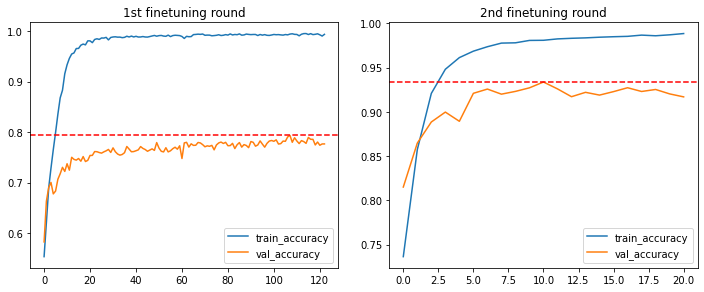

In [4]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title, label='best:0.999')
    bs = train_result['best_score']
    ax.axhline(y=bs, ls='--', c='red')
#     ax.annotate('%0.2f' % bs, (10, bs+0.01))
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0], 
                  title='1st finetuning round')
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1], 
                  title='2nd finetuning round')


## Loading final fine-tuned model

In [5]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True)
model.add_pred_listener(eval_recoder)

2021-10-05 04:15:20 [INFO]: Create TAPE model using config: ../config/bert-base/
2021-10-05 04:15:22 [INFO]: Loading the eval model from ../output/exp1/train.1.model_10.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1)
            )
     

## 모델 평가와 결과분석

### Shomuradova et al

- Performance evaluation for the dataset containing COVID-19 S-protein269-277(YLQPRTFLL) epitope with the 352 epitope-specific TCRβs from {Shomuradova:2020}
- TCR3b sequence motifs와 attention weights와의 상관관계는?

#### Exploring eval dataset

In [6]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset
import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope = 'YLQPRTFLL'

eval_key = 'shomuradova'
eval_ds = TCREpitopeSentenceDataset.from_key(eval_key)
eval_df = eval_ds.df_enc

print(eval_ds.name)
print('eval_df.shape: %s, duplicated: %s' % (str(eval_df.shape), np.count_nonzero(eval_df.index.duplicated())))
print(eval_df[CN.label].value_counts())

shomuradova
eval_df.shape: (610, 9), duplicated: 0
0    305
1    305
Name: label, dtype: int64


#### Evaluation performance

2021-10-05 04:15:53 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
2021-10-05 04:15:53 [INFO]: ======================
2021-10-05 04:15:53 [INFO]: Begin predict...
2021-10-05 04:15:53 [INFO]: use_cuda, device: False, cpu
2021-10-05 04:15:53 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=Tru

2021-10-05 04:15:53 [INFO]: n_data: 610
2021-10-05 04:15:53 [INFO]: batch_size: 610
2021-10-05 04:15:53 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-10-05 04:15:54 [INFO]: Begin 0/1 prediction batch
2021-10-05 04:16:02 [INFO]: End 0/1 prediction batch
2021-10-05 04:16:02 [INFO]: [PredResultRecoder]: on_predict_end...
2021-10-05 04:16:02 [INFO]: Done to predict...
2021-10-05 04:16:02 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9459016393442623), ('f1', 0.9454545454545454), ('roc_auc', 0.9789518946519754)])


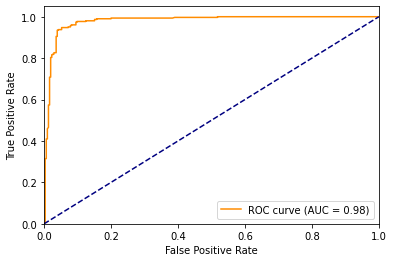

In [7]:
%pylab inline

from sklearn.metrics import roc_curve, auc

metrics = ['accuracy', 'f1', 'roc_auc']
eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)
model.predict(data_loader=eval_data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

#### Length distributions of CDR3beta sequences

- Model에 의해 Positive/Negative로 분류된 CDR3beta 서열의 길이 분포를 알아본다

2021-10-05 04:16:07 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
pos_indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 123 124 125 127 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210

Text(0.5, 24.0, 'Length')

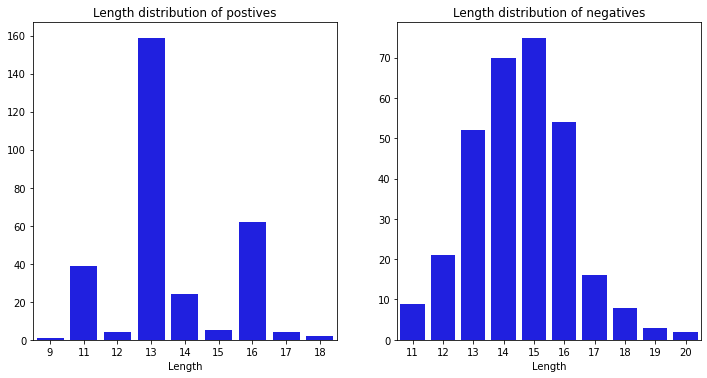

In [8]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

# pos_slogo = image.imread('../output/shomuradova.pos_cdr3b_seqlogo.jpeg')
# axes[1][0].set_title('SeqLogo for positive MSA')
# axes[1][0].set_axis_off()
# axes[1][0].imshow(pos_slogo, aspect='equal')

# neg_slogo = image.imread('../output/shomuradova.neg_cdr3b_seqlogo.jpeg')
# axes[1][1].set_title('SeqLogo for negative MSA')
# axes[1][1].set_axis_off()
# axes[1][1].imshow(neg_slogo, aspect='equal')

- Length distribution
    - Positive의 경우, 대부분의 서열 길이는 13이고 뒤를 이어 16, 11에 몰려 있다
    - Negative의 경우, 11-18 길이로 골고루 분포되어 있으며, 14, 15에 가장 많이 있다.  

<strike>
- MSA
    - Positive의 경우, 1-3번 위치에 C, A, <b>8번 위치에 P</b>, 16-20번 위치에 E, F가 모티프
    - Negative의 경우, 1-3번 위치에 C, A, 4, 5번 위치에 S, 18-21번 위치에 각각 E, Q, F, 22-25번에 P, Q, H, F가 모티프

- Positive/negative MSA 간의 모티프 차이점
    - 앞단 위치의 모티프 구성: pos=>CCA, neg=>CCASS
    - Positive MSA의 8번 위치의 P
    - 말단 위치에서의 positive의 경우 E, F로 모티프가 구성되는 반면, negative의 경우 E, Q, F로 구성되는 점
    - Positive MSA에서는 나타나지 않은 negative의 최말단에 P, Q, H, F로 구성되는 모티프가 있음
</strike>

#### Investigation of attention weights in YLQPRTFLL-CDR3b sequences 
- 전형적인 epitope-specific TCR recognition에서의 position-specific 아미노산 모티프들을 식별하는 방법들은 TCR 서열들의 MSA로 부터 유도되는 진화적 보존도를 기반으로 한다.

- 이러한 방법들은 TCR 서열들의 MSA를 기반으로 하고 있기 때문에 에피토프 펩타이드 서열에서의 모티프를 함께 식별해내기 어렵다.

- 최근에, BERTology는 TAPE, ProtAlbert 등과 같은 protein Transformer 모델의 output attention을 통하여 단백질 접힘 구조와 타겟 단백질에서의 functional 결합 사이트 등과 같은 단백질의 생물학적 특징들을 효과적으로 캡쳐할 수 있음을 증명하였다{Vig, J:2020}

- YLQPRTFLL 에피토프와 TCR 상호작용에서의 position-specific 아미노산 모티프를 식별하기 위하여 positive 데이터셋의 epitope-CDR3beta 서열 상에서 우리의 모델 output attention weight를 조사하였다. 이러한 방법은 epitope 펩타이드 서열과 TCR 서열 모두 동시에 고려하기 때문에 더욱 유용할 것이라 판단된다.
- Positive로 분류된 epitope-TCR 서열데이터 중에서 가장 많은 13mer TCR CDR3b 서열을 대상으로 고정길이 22 길이의 epitope-TCR CDR3b 서열에 대한 output attention 가중치를 조사하였다.
- epitope-TCRb 서열에서의 position-wise marginal weights(수식?)를 bar plot으로 도식화한다.
- 각각의 epitope TCRb 서열에서 상위 10%에 해당하는 위치에 tick label 아래에 점을 표시하였다.

##### Target CDR3b sequence motifs using MSA

2021-10-05 04:16:19 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
target_indices: [  0   1   2   3   5   7   9  11  13  15  18  19  20  21  22  23  24  25
  27  28  31  32  33  35  37  39  43  51  52  57  59  62  65  67  70  71
  74  75  76  78  79  81  82  88  89  90  91  92  93  94  97  99 100 110
 111 113 115 117 118 119 120 123 124 127 129 134 138 139 142 146 147 149
 150 153 154 155 156 158 160 161 162 166 168 169 170 172 173 174 175 176
 177 178 179 180 185 186 188 189 190 192 193 194 197 198 201 202 203 205
 207 211 213 214 217 219 220 223 225 228 231 233 234 237 238 239 240 243
 244 245 247 250 251 252 254 256 261 263 266 267 268 270 271 273 275 277
 279 280 287 289 290 291 292 294 295 296 298 312 533 548 595](159)
target epitope-CDR3b sequences: Index(['YLQPRTFLL_CASSFQNTGELFF', 'YLQPRTFLL_CASSSVNNNEQFF',
       'YLQPRTFLL_CAVGEANTGELFF', 'YLQPRTFLL_CAYQEVNTGELFF',
       'YLQPRTF

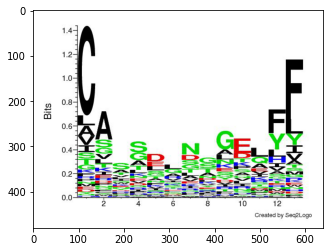

In [9]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as img

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope_len = len(epitope)
tcr_len = 13
sent_len = epitope_len + tcr_len

target_indices = np.where((output_labels == 1) & (eval_df[CN.cdr3b].map(lambda x: len(x) == tcr_len)))[0]
print('target_indices: %s(%s)' % (target_indices, len(target_indices)))
print('target epitope-CDR3b sequences: %s' % eval_df.index[target_indices])

target_cdr3b = eval_df[CN.cdr3b].values[target_indices]
fn_fa = '%s/%s.cdr3b.fa' % (outdir, eval_ds.name)
print('Writing target_cdr3b seqs to %s' % fn_fa)
write_fa(fn_fa, target_cdr3b)


image = img.imread(fn_fa.replace('fa', 'jpeg'))
plt.imshow(image)

2021-10-05 04:16:28 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
target_attns.shape: (12, 159, 12, 40, 40)
target_attns: [0.01643374 0.01618483 0.01511986 0.02533049 0.01850352 0.01619732
 0.02031346 0.01818909 0.02093069 0.02580083 0.02896048 0.02805906
 0.03447687 0.03893697 0.04397228 0.04865679 0.04153173 0.03341786
 0.03399991 0.03015553 0.0324808  0.02483021]


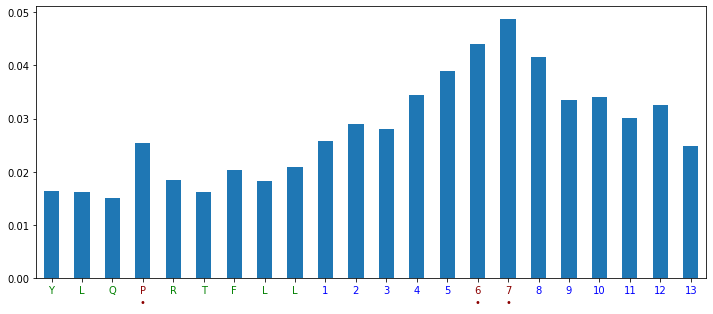

In [10]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

target_attns = attentions[:,target_indices]
print('target_attns.shape: %s' % str(target_attns.shape))

# Position-wise marginal attentions by mean
target_attns = np.mean(target_attns, axis=(0, 1, 2, 3))[1:sent_len+1]
print('target_attns: %s' % target_attns)

ticks = list(epitope) + list(range(1, tcr_len + 1))
mark_ratio = 0.1
mark_pos = []

for rank, pos in enumerate(np.argsort(target_attns[:epitope_len])[::-1]):
    if rank < (epitope_len*mark_ratio):
        ticks[pos] = '%s\n•' % (ticks[pos])
        mark_pos.append(pos)
    
for rank, pos in enumerate(np.argsort(target_attns[epitope_len:])[::-1]):
    if rank < (tcr_len*mark_ratio):
        ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
        mark_pos.append(epitope_len+pos)
        
ax = pd.Series(target_attns).plot(kind='bar', figsize=(12, 5), rot=0)
ax.set_xticklabels(ticks)
for i, tick in enumerate(ax.get_xticklabels()):
    if i < epitope_len:
        tick.set_color('green')
    else:
        tick.set_color('blue')
    if i in mark_pos:
        tick.set_color('darkred')
    

- 위 barplot에서 보는 바와 같이 YLQPRTFLL 에피토프의 4번 위치의 P에 높은 attention 가중치가 나왔다. 이는 TCR-epitope 상호작용에 있어서 4번 위치의 P가 높은 기여를 한다는 것을 보여 준다.
- Spike 단백질에서의 P272L 변이(YLQPRTFLL 에피토프의 4번 아미노산 위치)는 유럽에서의 'second pandemic wave'와 매우 밀접한 관련이 있는 거으로 알려져 있다.
- 몇달 전에 Dolton et al{Garry Dolton:2021}은 COVID-19에서 완치된 환자 코호트에서의 CD8 T-cell들이 P272L variant에 면역 대응을 하지 못했다는 것을 실험적으로 증명하였다. 또한 현재 승인된 백신으로 면역화된 개인들로부터 유도된 CD8 T-cell들이 P272 mutant를 제대로 인지하지 못한다는 것을 알아 냈다(https://www.news-medical.net/news/20210629/Widespread-SARS-CoV-2-mutation-escapes-vaccine-and-infection-induced-CD8-T-cell-responses.aspx).
> The spike protein mediates the initial stage of the SARS-CoV-2 infection process and is the structure that currently-approved COVID-19 vaccines have been based on.  
The spike mutation – P272L – has so far arisen in five different SARS-CoV-2 lineages, including the B.1.177 lineage that was associated with a second pandemic wave in Europe.
Now, a team from Cardiff University, Cardiff University School of Medicine, the University of Oxford, and the COVID-19 Genomics UK consortium have shown that CD8 T-cells from a cohort of convalescent patients that comprised more than 120 different T cell receptors (TCRs) failed to respond to the P272L variant.
Furthermore, sizeable populations of CD8 T-cells from individuals immunized with the currently approved COVID-19  vaccines failed to bind to a P272L reagent.

- 또한, TCR CDR3b 서열에서 attention 가중치가 상대적으로 높은 위치는 6, 7번이다. 아마도 이 위치의 TCR 아미노산 잔기들이 에피토프 펩타이드의 4번 위치의 P와 상대적으로 높은 상호작용을 하여 TCR 분자의 epitope recognition에 유의한 기여를 할 것으로 판단된다.

### ImmuneCODE

-  The dataset contained 415 COVID-19 S-protein269-277-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereon referred to as ImmuneCODE dataset

#### Exploring eval dataset

In [11]:
eval_key = 'immunecode'
eval_ds = TCREpitopeSentenceDataset.from_key(eval_key)
eval_df = eval_ds.df_enc

print(eval_ds.name)
print('eval_df.shape: %s, duplicated: %s' % (str(eval_df.shape), np.count_nonzero(eval_df.index.duplicated())))
print(eval_df[CN.label].value_counts())

immunecode
eval_df.shape: (746, 9), duplicated: 0
0    400
1    346
Name: label, dtype: int64


#### Evaluation performance

2021-10-05 04:16:59 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
2021-10-05 04:16:59 [INFO]: ======================
2021-10-05 04:16:59 [INFO]: Begin predict...
2021-10-05 04:16:59 [INFO]: use_cuda, device: False, cpu
2021-10-05 04:16:59 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=Tru

2021-10-05 04:16:59 [INFO]: n_data: 746
2021-10-05 04:16:59 [INFO]: batch_size: 746
2021-10-05 04:16:59 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-10-05 04:16:59 [INFO]: Begin 0/1 prediction batch
2021-10-05 04:17:08 [INFO]: End 0/1 prediction batch
2021-10-05 04:17:08 [INFO]: [PredResultRecoder]: on_predict_end...
2021-10-05 04:17:08 [INFO]: Done to predict...
2021-10-05 04:17:08 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9490616621983914), ('f1', 0.9457142857142857), ('roc_auc', 0.9833489884393063)])


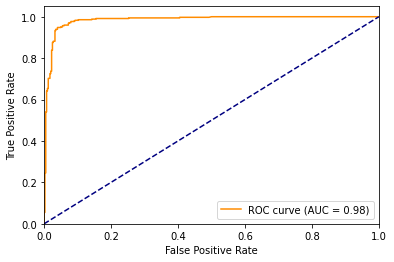

In [12]:
%pylab inline

from sklearn.metrics import roc_curve, auc

eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)
model.predict(data_loader=eval_data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

In [13]:
print(eval_ds.name)

immunecode


#### CDR3beta sequence length distribution

2021-10-05 04:17:27 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
pos_indices: [  0   1   3   4   5   6   7   8  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  76  77
  78  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 113 114 115 116
 118 119 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213

Text(0.5, 24.0, 'Length')

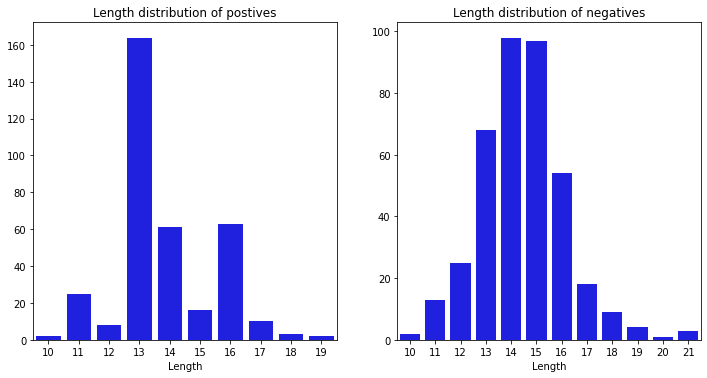

In [14]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

# pos_slogo = image.imread('../output/shomuradova.pos_cdr3b_seqlogo.jpeg')
# axes[1][0].set_title('SeqLogo for positive MSA')
# axes[1][0].set_axis_off()
# axes[1][0].imshow(pos_slogo, aspect='equal')

# neg_slogo = image.imread('../output/shomuradova.neg_cdr3b_seqlogo.jpeg')
# axes[1][1].set_title('SeqLogo for negative MSA')
# axes[1][1].set_axis_off()
# axes[1][1].imshow(neg_slogo, aspect='equal')

- Length distribution
    - Positive의 경우, 대부분의 서열 길이는 13이고 뒤를 이어 14, 16에 몰려 있다
    - Negative의 경우, 대부분 14, 15이고 뒤를 이어 13, 17에 몰려 있다 

#### Investigation of attention weights

##### Target CDR3b sequence motifs using MSA

2021-10-05 04:17:56 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
target_indices: [  0   6  10  12  17  18  19  20  22  28  30  31  33  35  36  39  43  44
  45  46  47  48  49  50  51  52  57  61  62  66  69  70  72  75  76  78
  81  82  84  91  92  93  94  97  98 101 102 109 114 115 116 118 119 120
 122 123 124 127 135 136 138 140 142 144 148 150 155 157 158 161 165 167
 168 175 178 179 180 182 184 186 187 188 189 193 195 196 200 202 203 204
 206 208 211 212 213 214 215 216 219 221 222 223 224 229 232 233 236 237
 238 240 244 245 247 248 249 254 255 263 270 271 274 275 276 277 279 280
 281 282 285 296 297 298 299 302 305 306 308 309 311 313 314 315 321 323
 325 327 329 331 334 335 336 337 338 341 342 343 344 345 375 426 428 546
 576 675](164)
target epitope-CDR3b sequences: Index(['YLQPRTFLL_CAKGLANTGELFF', 'YLQPRTFLL_CAGQESNTGELFF',
       'YLQPRTFLL_CATQDTNTGELFF', 'YLQPRTFLL_CASSDVDSGE

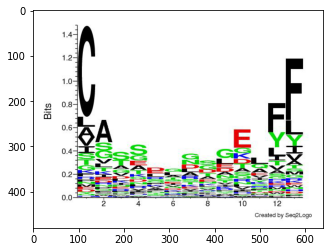

In [15]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as img

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope_len = len(epitope)
tcr_len = 13
sent_len = epitope_len + tcr_len

target_indices = np.where((output_labels == 1) & (eval_df[CN.cdr3b].map(lambda x: len(x) == tcr_len)))[0]
print('target_indices: %s(%s)' % (target_indices, len(target_indices)))
print('target epitope-CDR3b sequences: %s' % eval_df.index[target_indices])

target_cdr3b = eval_df[CN.cdr3b].values[target_indices]
fn_fa = '%s/%s.cdr3b.fa' % (outdir, eval_ds.name)
print('Writing target_cdr3b seqs to %s' % fn_fa)
write_fa(fn_fa, target_cdr3b)

image = img.imread(fn_fa.replace('fa', 'jpeg'))
plt.imshow(image)

##### Duplicated CDR3b sequences from Shomuradova dataset

In [16]:
from tcrbert.bioseq import read_fa

headers, sh_seqs = read_fa('%s/shomuradova.cdr3b.fa' % outdir)
headers, im_seqs = read_fa('%s/immunecode.cdr3b.fa' % outdir)

dup = np.intersect1d(sh_seqs, im_seqs)
print(dup, dup.shape)


['CAIQDLNTGELFF' 'CASSDGNTGELFF' 'CASSELNTGELFF' 'CASSSLNTGELFF'] (4,)


2021-10-05 04:18:35 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 746, 12, 40, 40)
target_attns.shape: (12, 164, 12, 40, 40)
target_attns: [0.01630659 0.01614023 0.0151215  0.02522748 0.0185223  0.01628857
 0.02040477 0.01823485 0.02074875 0.026072   0.02814894 0.02786717
 0.03495789 0.03859197 0.04388916 0.04902364 0.0410643  0.03343454
 0.0340478  0.03056218 0.03294009 0.02483094]


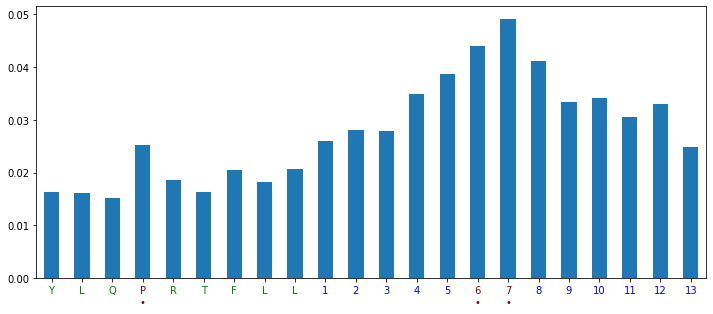

In [17]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

target_attns = attentions[:,target_indices]
print('target_attns.shape: %s' % str(target_attns.shape))

# Position-wise marginal attentions by mean
target_attns = np.mean(target_attns, axis=(0, 1, 2, 3))[1:sent_len+1]
print('target_attns: %s' % target_attns)
ticks = list(epitope) + list(range(1, tcr_len + 1))
mark_ratio = 0.1
mark_pos = []

for rank, pos in enumerate(np.argsort(target_attns[:epitope_len])[::-1]):
    if rank < (epitope_len*mark_ratio):
        ticks[pos] = '%s\n•' % (ticks[pos])
        mark_pos.append(pos)
    
for rank, pos in enumerate(np.argsort(target_attns[epitope_len:])[::-1]):
    if rank < (tcr_len*mark_ratio):
        ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
        mark_pos.append(epitope_len+pos)
        
ax = pd.Series(target_attns).plot(kind='bar', figsize=(12, 5), rot=0)
ax.set_xticklabels(ticks)
for i, tick in enumerate(ax.get_xticklabels()):
    if i < epitope_len:
        tick.set_color('green')
    else:
        tick.set_color('blue')
    if i in mark_pos:
        tick.set_color('darkred')
    

- Shomuradova 데이터셋의 결과와 거의 동일하게 일관성있는 결과를 보여준다.
- MSA를 기반으로 TCR CDR3beta 서열의 모티프를 살펴보면 6, 7, 8번은 그다지 conserved 되어 있지 않은 것으로 보인다. 이것으로 볼때, 에피토프와 높은 상호작용을 하는 TCR 서열 잔기 위치를 파악하는 데 있어 MSA 기반으로 conserved 모티프로부터 추론하는 방법도 전통적으로 유용하지만 attention weight로부터 유추하는 것도 더욱 심플하고 epitope 서열상의 모티프로 함께 분석할 수 있어 효과적일 수 있다는 것을 알 수 있다.